In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tda.sim.sim_engine import Simulation
from tda.sim.sim_objects.lti_object import LTIObject
from tda.sim.sensors import clutter_model
from tda.sim.sensors.radar import Radar

from tda.tracker.filters.extended_kalman import ExtendedKalman

In [2]:
sim = Simulation()

R = np.array([[np.pi / 180, 0, 0],
              [0, np.pi / 180, 0],
              [0, 0, 10]])

platform = LTIObject(1, np.array([0, 50, 0]), sim, np.zeros((3, 3)))
radar = Radar(1, platform, 5.0, R)
platform.add_payload(radar)

target_Q = np.zeros((6, 6))
target_Q[0, 0] = 0.25
target_Q[1, 1] = 0.33
target_Q[2, 2] = 1e-6
target_Q[3, 3] = 1e-6
target_Q[4, 4] = 1e-6
target_Q[5, 5] = 1e-6


target = LTIObject(2, np.array([10, 12, 0, 1, 2, 0]), sim, target_Q)

sim._sim_objects.extend([platform, target])

In [3]:
sim_records = sim.run()

In [4]:
sim_records

{'radar1': {'t': array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]),
  'sensor_id': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
  'target_id': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
  'target_az': array([-1.03033747, -1.13049313, -0.4565308 , -0.41230889, -0.0067943 ,
          0.38134709,  0.17756066,  0.6110971 ,  0.57523003,  0.69256353,
          0.8289524 ,  0.81676616,  1.0566257 ]),
  'target_el': array([1.58500518, 1.71595704, 1.70115081, 1.30728203, 1.34981642,
         1.63697906, 1.44953765, 1.49030742, 1.76764318, 1.57431066,
         1.64046377, 1.75248531, 1.42779842]),
  'target_rng': array([ 33.78865881,  35.86233321,  29.38556441,  25.38187063,
          27.68713403,  39.70328061,  44.69010758,  51.37969855,
          68.6258219 ,  77.89004447,  87.61908298, 110.31722105,
         106.48308761]),
  'sensor_x': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'sensor_y': array([50., 50., 50., 50.

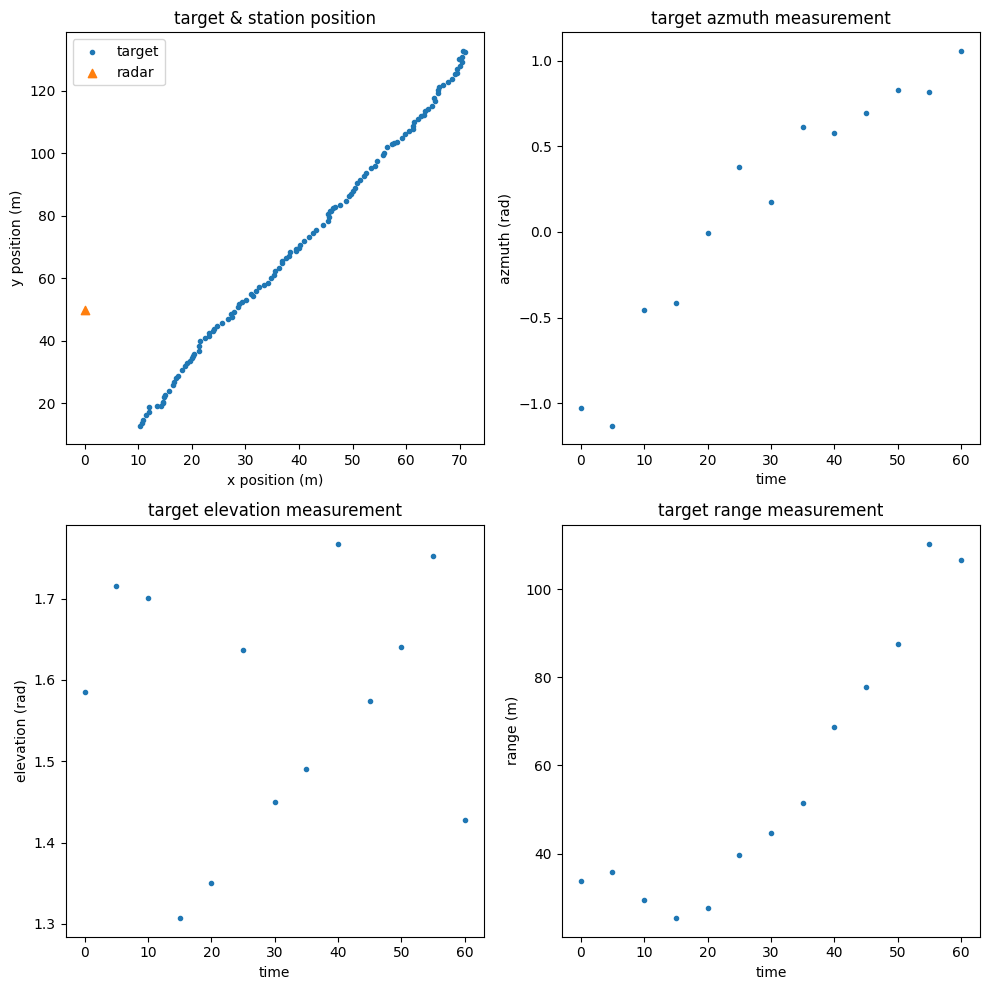

In [5]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches((10, 10))

axs[0, 0].scatter(sim_records["lti_object2"]["x"], sim_records["lti_object2"]["y"], marker=".", label="target")
axs[0, 0].scatter(sim_records["lti_object1"]["x"][0], sim_records["lti_object1"]["y"][0], marker="^", label="radar")
axs[0, 0].set_title("target & station position")
axs[0, 0].set_xlabel("x position (m)")
axs[0, 0].set_ylabel("y position (m)")
axs[0, 0].legend()

axs[0, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_az"], marker=".")
axs[0, 1].set_title("target azmuth measurement")
axs[0, 1].set_xlabel("time")
axs[0, 1].set_ylabel("azmuth (rad)")

axs[1, 0].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_el"], marker=".")
axs[1, 0].set_title("target elevation measurement")
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("elevation (rad)")

axs[1, 1].scatter(sim_records["radar1"]["t"], sim_records["radar1"]["target_rng"], marker=".")
axs[1, 1].set_title("target range measurement")
axs[1, 1].set_xlabel("time")
axs[1, 1].set_ylabel("range (m)")

fig.tight_layout()

In [7]:
def get_F(dt: float):
    F = np.eye(6, dtype=np.float64)
    F[0, 3] = F[1, 4] = F[2, 5] = dt
    #F[3, 6] = F[4, 7] = F[5, 8] = dt
    #F[0, 6] = F[1, 7] = F[2, 8] = (dt ** 2) / 2

    return F


def f(dt, x):
    return get_F(dt) @ x


def h(x):
    rho = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    the = np.arctan2(x[1], x[0])
    psi = np.arccos(x[2] / rho)
    
    return np.array([the, psi, rho])


def get_H(X):
    x = X[0]
    y = X[1]
    z = X[2]
    
    return np.array([[-y/(x**2 + y**2), x/(x**2 + y**2), 0, 0, 0, 0],
                     [(x*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), (y*z)/((1 - z**2/(x**2 + y**2 + z**2))**(1/2)*(x**2 + y**2 + z**2)**(3/2)), -(1/(x**2 + y**2 + z**2)**(1/2) - z**2/(x**2 + y**2 + z**2)**(3/2))/(1 - z**2/(x**2 + y**2 + z**2))**(1/2), 0, 0, 0],
                     [x/(x**2 + y**2 + z**2)**(1/2), y/(x**2 + y**2 + z**2)**(1/2), z/(x**2 + y**2 + z**2)**(1/2), 0, 0, 0]
                    ])


def Q(dt: float):
    Q = np.zeros((6, 6))
    Q[0, 0] = 0.35
    Q[1, 1] = 0.35

    return dt * Q

x_hat_0 = np.ones(6)
P_hat_0 = 1e9 * np.eye(6)

kf = ExtendedKalman(x_hat_0, P_hat_0, f, get_F, h, get_H, Q, R)

for frame in sim.meas_queue:
    for m in frame:
        kf.update(m)

kf_record = kf.record()

In [8]:
kf._filter_history

[(0.0,
  array([25.02987655, 17.766934  , 18.72686295, 12.51493827,  8.883467  ,
          9.36343147]),
  array([[3.43805295e+00, 3.29842678e+00, 3.26352037e+00, 1.71902648e+00,
          1.64921339e+00, 1.63176018e+00],
         [3.29842665e+00, 3.43805295e+00, 3.26352024e+00, 1.64921332e+00,
          1.71902648e+00, 1.63176012e+00],
         [3.26352029e+00, 3.26352029e+00, 3.47295948e+00, 1.63176015e+00,
          1.63176015e+00, 1.73647974e+00],
         [1.71902668e+00, 1.64921338e+00, 1.63176017e+00, 5.00000001e+08,
          8.24606690e-01, 8.15880087e-01],
         [1.64921338e+00, 1.71902657e+00, 1.63176023e+00, 8.24606690e-01,
          5.00000001e+08, 8.15880115e-01],
         [1.63176015e+00, 1.63176015e+00, 1.73647976e+00, 8.15880073e-01,
          8.15880073e-01, 5.00000001e+08]])),
 (5.0,
  array([233.26193969, -64.68547183,  -8.95204967,  41.64641263,
         -16.49048115,  -5.53578251]),
  array([[122.19390357, -56.24847693, -96.59047537,  24.43878071,
          -11

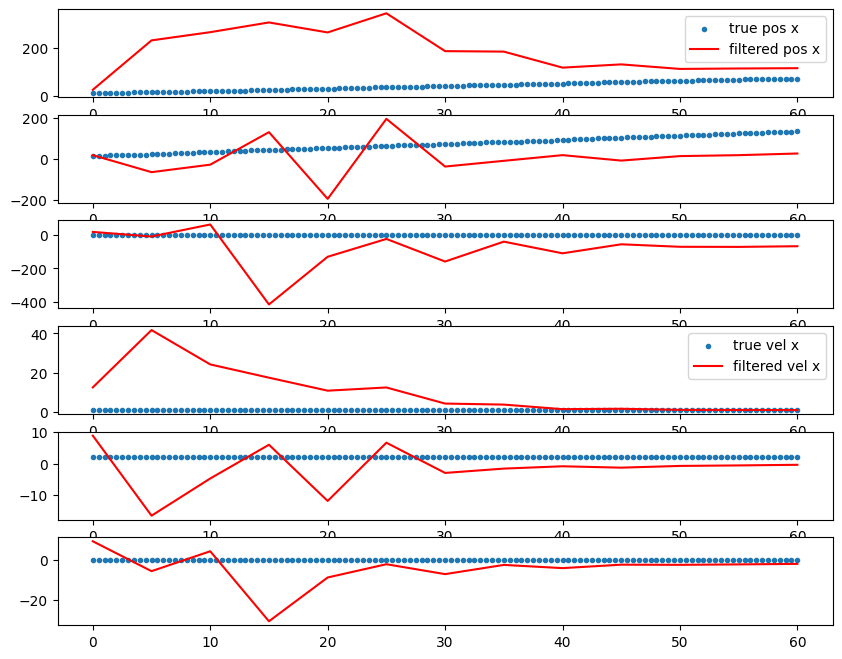

In [10]:
fig, axs = plt.subplots(6)
fig.set_size_inches((10, 8))
axs[0].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["x"], marker=".", label="true pos x")
#axs[0].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_x"], marker="x", label="measured pos x")
axs[0].plot(kf_record["t"], kf_record["x_hat"][:, 0], color="red", label="filtered pos x")
axs[0].legend()

axs[1].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["y"], marker=".", label="true pos y")
#axs[1].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_y"], marker="x", label="measured pos y")
axs[1].plot(kf_record["t"], kf_record["x_hat"][:, 1], color="red", label="filtered pos y")

axs[2].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["z"], marker=".", label="true pos z")
#axs[2].scatter(sim_records["oracle1"]["t"], sim_records["oracle1"]["target_z"], marker="x", label="measured pos z")
axs[2].plot(kf_record["t"], kf_record["x_hat"][:, 2], color="red", label="filtered pos z")

axs[3].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["xdot"], marker=".", label="true vel x")
axs[3].plot(kf_record["t"], kf_record["x_hat"][:, 3], color="red", label="filtered vel x")
axs[3].legend()

axs[4].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["ydot"], marker=".", label="true vel y")
axs[4].plot(kf_record["t"], kf_record["x_hat"][:, 4], color="red", label="filtered pos y")

axs[5].scatter(sim_records["lti_object2"]["t"], sim_records["lti_object2"]["zdot"], marker=".", label="true vel z")
axs[5].plot(kf_record["t"], kf_record["x_hat"][:, 5], color="red", label="filtered pos z")